In [43]:
import pandas as pd 

# 윈도우 환경에서 파일을 그대로 읽으면 유니코드 에러 발생, encoding을 CP949로 강제 지정해준다
data = pd.read_csv('Input/DFE_project_data_raw.csv')
## data = pd.read_csv('../Input/creditcard.csv',header=None)

In [44]:
# Graph에서 한글 폰트가 깨지는 문제 해결용
from matplotlib.pyplot import rc
rc('font',family='New Gulim')

In [45]:
print("기업후기 -  rows:",data.shape[0]," columns:", data.shape[1])

기업후기 -  rows: 563922  columns: 18


In [46]:
data.keys()

Index(['회사이름', '회사코드', '리뷰코드', '직종구분', '재직상태', '근무지역', '등록일자', '별점평가', '승진기회',
       '복지급여', '워라밸', '사내문화', '경영진', '기업장점', '기업단점', '바라는점', '성장예상', '추천여부'],
      dtype='object')

In [47]:
data.head(2)

,회사이름,회사코드,리뷰코드,직종구분,재직상태,근무지역,등록일자,별점평가,승진기회,복지급여,워라밸,사내문화,경영진,기업장점,기업단점,바라는점,성장예상,추천여부
0,삼성전자(주),30139,1084668,경영/기획/컨설팅,전직원,해외,2019-04-18,80,80,80,60,60,80,연봉과 복리후생이 매우 좋으며 열심히 하면(운도 필요하지만) 기회가 주어지는 곳. ...,"조직이 방대하여 의사결정이 느리고 소통이 잘 되지 않음. 보신주의, 상명하복, 줄서...",단기 성과주의를 경계해야 함. 최고경영진은 장기비전과 미래를 고민하나 적지 않은 수...,비슷,이 기업을 추천 합니다!
1,삼성전자(주),30139,1084223,생산관리/품질관리,전직원,경기,2019-04-18,80,60,100,80,80,80,글로벌 1위기업답게 체계적인 시스템으로 돌아가는 조직문화와 업무진행,굉장히 전문적이라서 본인의 업무외엔 전혀 모름다양하게 배우기는 어려움,다양한 조직문화 활동으로 많이 좋아지고 있지만아직도 갑질 문화가 남아있다. 근절이 필요!,성장,이 기업을 추천 합니다!


## Data Cleansing

In [48]:
# 결측치(np.nan)가 있는 경우 삭제 : 404099개 리뷰
data = data.dropna(axis=0)

In [49]:
# print("기업후기 -  rows:",data.shape[0]," columns:", data.shape[1])

#### 추천여부를 0,1 numeric type으로 표현하여 저장 : RECOM_TF

In [50]:
def clean(x):
    x = x.replace("이 기업을 추천 합니다!", "1").replace("이 기업을 추천하지 않습니다.", "0")
    return float(x)

In [51]:
# 데이터 전처리 
data['RECOM_TF'] = data['추천여부'].apply(clean)

#### Regression에 필요한 numeric만 추출

In [52]:
dataset = data.filter(['별점평가','승진기회','복지급여','워라밸','사내문화','경영진','RECOM_TF'], axis=1)

In [53]:
dataset.head()

,별점평가,승진기회,복지급여,워라밸,사내문화,경영진,RECOM_TF
0,80,80,80,60,60,80,1.0
1,80,60,100,80,80,80,1.0
2,80,20,100,100,80,80,1.0
3,80,60,100,100,60,60,1.0
4,60,60,100,40,60,60,1.0


#### 총 별점평가가 최하점(20점)이면서 추천여부가 1(추천함)인 경우는 abnormal한 케이스로 보고 삭제 (783건)

In [54]:
dataset=dataset.drop(dataset[(dataset['별점평가']<=20)&(dataset['RECOM_TF']==1)].index)
#print("기업후기 -  rows:",dataset.shape[0]," columns:", dataset.shape[1])

#### 총 별점평가가 최고점(100점)이면서 추천여부를 0(추천안함)인 경우도 abnormal한 케이스로 보고 삭제 (2631건)

In [55]:
# dataset.loc[(dataset['별점평가']>=100)&(dataset['RECOM_TF']==0),:]
dataset=dataset.drop(dataset[(dataset['별점평가']>=100)&(dataset['RECOM_TF']==0)].index)
#print("기업후기 -  rows:",dataset.shape[0]," columns:", dataset.shape[1])

In [56]:
dataset['score_mean']=dataset.iloc[:,1:6].mean(axis=1)

In [57]:
dataset.head()

,별점평가,승진기회,복지급여,워라밸,사내문화,경영진,RECOM_TF,score_mean
0,80,80,80,60,60,80,1.0,72.0
1,80,60,100,80,80,80,1.0,80.0
2,80,20,100,100,80,80,1.0,76.0
3,80,60,100,100,60,60,1.0,76.0
4,60,60,100,40,60,60,1.0,64.0


#### 개별 평가항목 5개(승진기회~경영진)가 최하점이면서 추천여부가 1(추천함)인 경우는 abnormal한 케이스로 보고 삭제 (77건)

In [58]:
dataset=dataset.drop(dataset[(dataset['score_mean']<=20)&(dataset['RECOM_TF']==1)].index)
# dataset.loc[(dataset['score_mean']<=20)&(dataset['RECOM_TF']==1),:]

#### 개별 평가항목 5개(승진기회~경영진)가 최고점(100점)이면서 추천여부가 0(추천안함)인 경우도 abnormal한 케이스로 보고 삭제 (59건)

In [59]:
dataset=dataset.drop(dataset[(dataset['score_mean']>=100)&(dataset['RECOM_TF']==0)].index)
# dataset.loc[(dataset['score_mean']>=100)&(dataset['RECOM_TF']==0),:]

In [60]:
print("클렌징 후 총 데이터 건수 :",dataset.shape[0])

클렌징 후 총 데이터 건수 : 400549


## Exploratory Data Analysis

In [61]:
Y = dataset['RECOM_TF']
X = dataset.iloc[:,0:6]
X.head()

,별점평가,승진기회,복지급여,워라밸,사내문화,경영진
0,80,80,80,60,60,80
1,80,60,100,80,80,80
2,80,20,100,100,80,80
3,80,60,100,100,60,60
4,60,60,100,40,60,60


In [62]:
# feature 간의 상관관계
X.corr()

,별점평가,승진기회,복지급여,워라밸,사내문화,경영진
별점평가,1.000000,0.553636,0.619037,0.563168,0.635461,0.658664
승진기회,0.553636,1.000000,0.458853,0.284304,0.431471,0.495167
복지급여,0.619037,0.458853,1.000000,0.381451,0.413708,0.500155
워라밸,0.563168,0.284304,0.381451,1.000000,0.530932,0.455843
사내문화,0.635461,0.431471,0.413708,0.530932,1.000000,0.604229
경영진,0.658664,0.495167,0.500155,0.455843,0.604229,1.000000


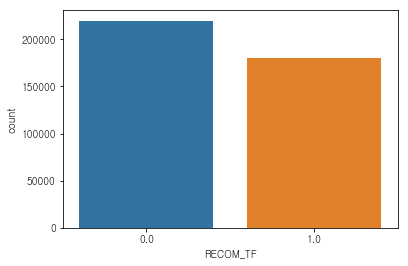

In [63]:
# 0: 기업을 추천하지 않음 / 1 : 기업을 추천함
import seaborn as sns
import matplotlib.pyplot as plt


sns.countplot(x='RECOM_TF', data=dataset)
plt.show()

In [64]:
X.mean()

별점평가    60.089477
승진기회    57.989310
복지급여    57.305174
워라밸     57.241910
사내문화    58.851152
경영진     51.444817
dtype: float64

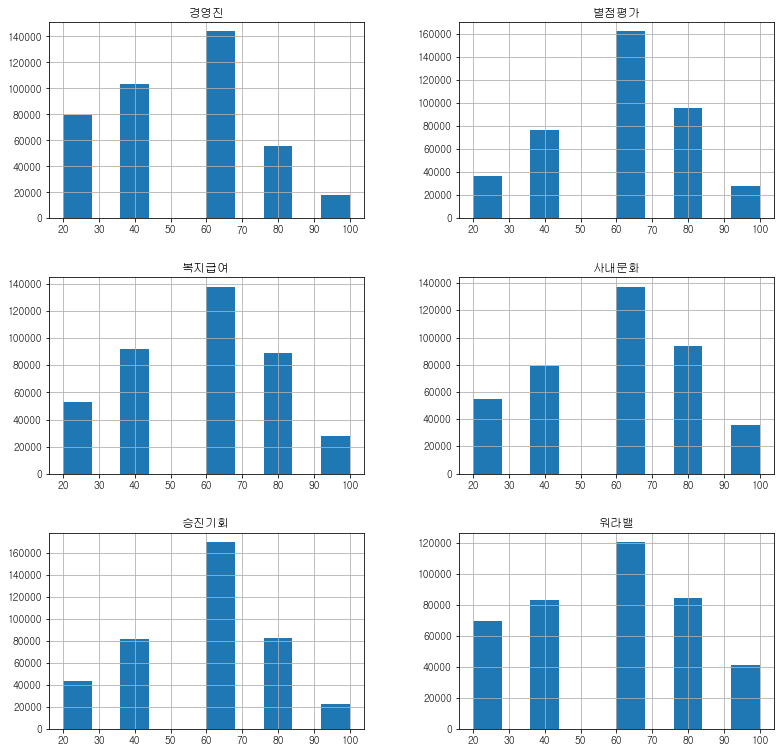

In [65]:
# Feature별 histogram
X.hist(figsize = (13,13))
plt.show()

## Logistic Regression

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
lr = LogisticRegression(C=0.015)

In [70]:
lr.fit(X_train,y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.015, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [71]:
lr.score(X_train,y_train)

0.8165979513809632

In [72]:
# 여러 번 시도해봤는데 accuracy가 대략 81 수준
lr.score(X_test, y_test)

0.8165772063412807

In [73]:
predicted_lr = lr.predict(X_test)

In [74]:
from sklearn.metrics import classification_report

In [75]:
print(classification_report(y_test, predicted_lr))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84     65965
         1.0       0.82      0.76      0.79     54200

   micro avg       0.82      0.82      0.82    120165
   macro avg       0.82      0.81      0.81    120165
weighted avg       0.82      0.82      0.82    120165



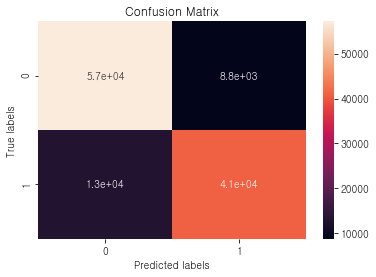

In [76]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted_lr))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

## Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [79]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=2)

In [80]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=2, verbose=0, warm_start=False)

In [81]:
rf.score(X_train, y_train)

0.8219584569732937

In [82]:
rf.score(X_test, y_test)

0.815653476469854

In [83]:
predicted_rf = rf.predict(X_test)

In [84]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predicted_rf)

### Out-of-bag error: RF에서 훈련 때 사용되지 않은 샘플들을 가지고 테스트하여 모델의 성능을 예측
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.812
Mean accuracy score: 0.816


In [85]:
print(classification_report(y_test, predicted_rf))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     65972
         1.0       0.79      0.80      0.80     54193

   micro avg       0.82      0.82      0.82    120165
   macro avg       0.81      0.81      0.81    120165
weighted avg       0.82      0.82      0.82    120165



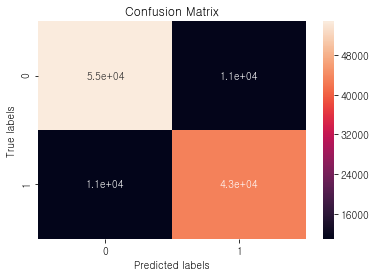

In [86]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted_rf))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

#### 위에서 test set에 대한 score 함수값(81%)만 봤을 땐 LR이나 RF나 큰 차이가 안 보였지만
#### F1-Score나 Confusion Matrix 시각화 결과를 보면 <br>RandomForest가 F1-Score도 조금 더 낫게 나오고 <br>Matrix에서 (Logistic Regression)보다 TP 건수가 조금 더 많고 FN, FP 건수는 적은 것으로 보여짐...<br><br>RF가 조금 더 나은 것으로 추정

#### 구글링해보면 데이터가 balanced일 때는 Accuracy가 의미있지만, imbalanced data일 때는 F1-Score로 성능 평가해야 한다고 함
#### (Imbalanced Data에 대한 Accuracy 평가는 문제가 발생할 수 있음)

#### Linear Regression도 유사하게 진행 가능할 듯.. .더 의미있는 분석 필요~ ㅠㅠ

### 그 외에 성능 평가 시도

### (1) Cross Validation

데이터의 양이 충분히 많으므로 이 방식의 검증이 유효한지에 대해 약간 의문이 있음.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=2018)

In [ ]:
lr_scores = cross_val_score(lr, X, Y, cv=k_fold, scoring="accuracy")
print("Cross Validation Scores:", format(lr_scores))
print("Cross Validation Mean Scores:", format(lr_scores.mean()))

In [ ]:
scores = cross_val_score(rf, X, Y, cv=k_fold, scoring="accuracy")
print("Cross Validation Scores:", format(scores))
print("Cross Validation Mean Scores:", format(scores.mean()))

Logistic Regression : 0.81661170047397<br>
Random Forest : 0.8137081837904481

RF가 오히려 조금 더 낮게 나옴 - 이 집계는 그냥 빼고 스킵하자...

### (2) ROC Curve

In [88]:
from sklearn.metrics import roc_curve

In [ ]:
y_scores = lr.decision_function(X_train)

In [90]:
y_forest_scores = rf.predict_proba(X_train)[:,1]

In [95]:
fpr_logistic, tpr_logistic, thresholds = roc_curve(y_train, y_scores)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

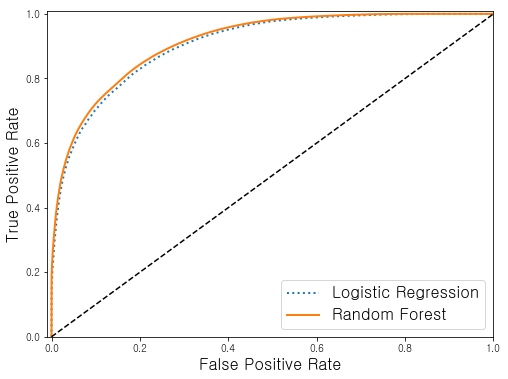

In [99]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, ':', linewidth=2, label='Logistic Regression')
plt.plot(fpr_forest, tpr_forest, linewidth=2, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1.01])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)


plt.show()

#### 두 개의 그래프가 거의 동일한데 RF가 아주 조금 더 위쪽에 위치하여 더 나은 성능을 보여주는 것으로 판단됨

### (3) AUC Score

In [98]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores), roc_auc_score(y_train, y_forest_scores)

(0.9063266615887088, 0.9136850898042395)

#### AUC값 역시 Random Forest일 경우 조금 더 높게 나타남